In [1]:
import datetime
from math import sqrt

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from domus_analytica.config import DomusSettings
from domus_analytica.data_clean import extract_info_to_table

config = DomusSettings(_env_file=".env.local")

# Extract Data and Preprocessing 

In [2]:
def data_preprocessing(data: pd.DataFrame):
    # Data preprocessing
    data["unit_price"] = data["price"] / data["exclusive_area"]
    data["completion_date_number"] = (
            pd.to_datetime(data["completion_date"]).astype(int)
            / (10 ** 9 * (24 * 60 * 60) * 365.25)
            + 1970
    )
    data["min_distance_to_busy_area"] = data[
        ["distance_to_hakata",
         "distance_to_ohori_park",
         "distance_to_tenjin"]
    ].min(axis=1)
    data["floor_ratio"] = data["floor"] * 1.0 / data["total_floors"]

    def direction_mapping(s: str) -> str:
        return s.replace("東", "E").replace("南", "S").replace("西", "W").replace("北", "N")

    data["direction"] = data["direction"].map(direction_mapping)

    data = pd.get_dummies(data, columns=["direction"], dtype="float32")
    data = pd.get_dummies(data, columns=["layout_main"], dtype="float32")
    data = pd.get_dummies(data, columns=["build_type"], dtype="float32")

    return data


df = data_preprocessing(
    extract_info_to_table(
        config,
        {'search_time': datetime.datetime(2024, 4, 1, 14, 46, 31, 449000)}
    )
)
df.head().transpose()

,0,1,2,3,4
id,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7437...,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7460...,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7250...,/ms/chuko/fukuoka/sc_fukuokashiminami/nc_73552...,/ms/chuko/fukuoka/sc_fukuokashihakata/nc_74582...
name,モントーレブルー・ラ・メール Fukuoka,ファーネスト箱崎公園,Asobi+ JGMヴェルデ香椎南弐番館,エイルヴィラクレアテュール井尻南II,アンピール吉塚
address,福岡県福岡市東区西戸崎２-1-30,福岡県福岡市東区松田２,福岡県福岡市東区八田１,福岡県福岡市南区曰佐２,福岡県福岡市博多区吉塚６
lat,33.6461037815746,33.6203572036973,33.63406257298,33.540890670713,33.6075918806721
lon,130.3599501447,130.443550474538,130.456704058744,130.438664435095,130.429482478425
price,2080.0,2080.0,2490.0,2580.0,2780.0
exclusive_area,57.25,69.85,93.33,75.42,65.1
common_area,11.04,38.1,24.55,20.88,14.0
completion_date,2007-01-01,2008-06-01,2001-06-01,1999-05-01,2000-11-01
layout_storage_room,0,0,0,0,0


# Train XGB model to predict unit price

In [3]:

from itertools import chain

import pandas as pd
from xgboost import XGBRegressor

feature_prefixes = ["direction_", "layout_main_", "build_type_"]
features = list(set(chain(
    [
        "min_distance_to_busy_area",
        "distance_to_nearest_station",
        "distance_to_hakata",
        "distance_to_ohori_park",
        "distance_to_tenjin",
        "min_distance_to_mafia",
        "min_distance_to_cemetery",
    ],
    [
        "bus_station_count",
        "restaurant_count",
        "supermarket_count",
        "convenience_store_count",
        "drugstore_count",
        "park_count",
        "cafe_count",
        "floor",
        "total_floors",
        "floor_ratio",
        "common_area",
        "layout_storage_room",
        "exclusive_area",
        "completion_date_number",
        "monthly_fee_total",
    ],
    *(
        [col for col in df.columns if col.startswith(feature_prefix)]
        for feature_prefix in feature_prefixes
    )
)))
target = "unit_price"

print("Using features: {} to predict {}".format(",".join(features), target))

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.1, random_state=123
)

model = XGBRegressor(n_estimators=5, max_depth=7, objective="reg:squarederror")
model.fit(X_train, y_train)
print(
    f"R-Square: Train={model.score(X_train, y_train)}, test={model.score(X_test, y_test)}"
)
print(
    f"単価のRMSE (万円): Train={sqrt(mean_squared_error(model.predict(X_train), y_train))}, test={sqrt(mean_squared_error(model.predict(X_test), y_test))}"
)

total_rmse_train = sqrt(
    mean_squared_error(
        model.predict(X_train) * X_train["exclusive_area"],
        y_train * X_train["exclusive_area"],
    )
)
total_rmse_test = sqrt(
    mean_squared_error(
        model.predict(X_test) * X_test["exclusive_area"],
        y_test * X_test["exclusive_area"],
    )
)
print(f"総金額のRMSE (万円): Train={total_rmse_train}, test={total_rmse_test}")
df["unit_price_estimate"] = model.predict(df[features])
df["price_estimate"] = df["unit_price_estimate"] * df["exclusive_area"]

Using features: direction_SE,direction_SW,direction_W,total_floors,supermarket_count,layout_main_4LDK,build_type_wood,layout_main_2LDK,restaurant_count,direction_NW,floor,distance_to_tenjin,convenience_store_count,distance_to_hakata,layout_main_3LK,direction_S,direction_E,direction_N,drugstore_count,distance_to_nearest_station,min_distance_to_cemetery,layout_main_3LDK,completion_date_number,build_type_unknown,floor_ratio,build_type_RC,min_distance_to_mafia,distance_to_ohori_park,monthly_fee_total,cafe_count,bus_station_count,common_area,exclusive_area,layout_main_2DK,direction_NE,park_count,min_distance_to_busy_area,layout_storage_room to predict unit_price
R-Square: Train=0.9240201914019716, test=0.8796114084044231
単価のRMSE (万円): Train=4.696292769229526, test=5.393956116239684
総金額のRMSE (万円): Train=377.5258575735982, test=482.4898160914948


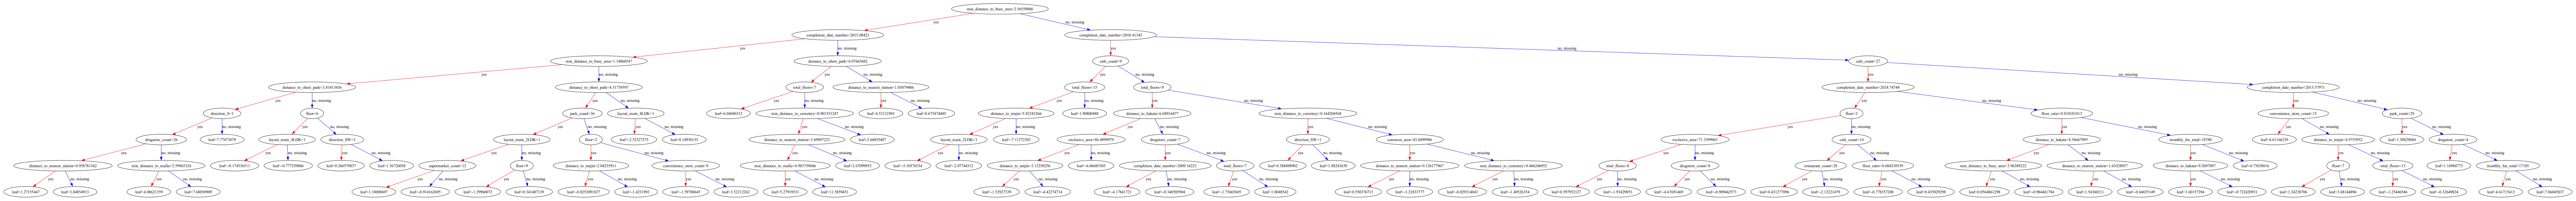

In [4]:
from xgboost import plot_tree
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [128, 32]
plot_tree(model)
plt.savefig("output/xgboost_model.png")

# Error Analysis

## Error Visualization for unit price

Mu=0.08520976782654865 Std=4.770911538923416


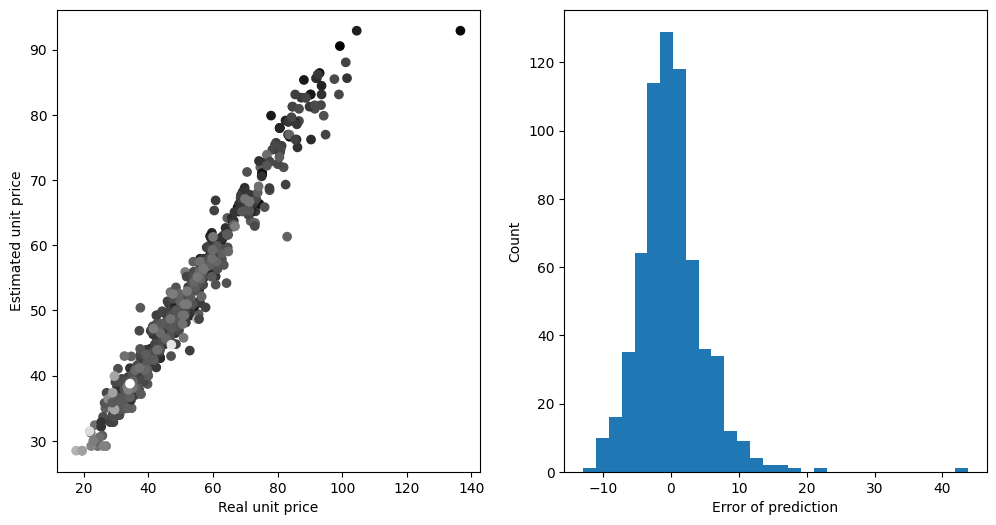

In [5]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6))
[ax1, ax2] = fig.subplots(1, 2)
_ = ax1.scatter(df["unit_price"], df["unit_price_estimate"], c=df["exclusive_area"], cmap="gray")
ax1.set_xlabel("Real unit price")
ax1.set_ylabel("Estimated unit price")
unit_price_error = df["unit_price"] - df["unit_price_estimate"]
_ = ax2.hist(unit_price_error, bins=30)
ax2.set_xlabel("Error of prediction")
ax2.set_ylabel("Count")
print(f"Mu={unit_price_error.to_numpy().mean()} Std={unit_price_error.to_numpy().std()}")

## Error Analysis for Total Price

Mu=-11.876048185521357 Std=389.2770166586401


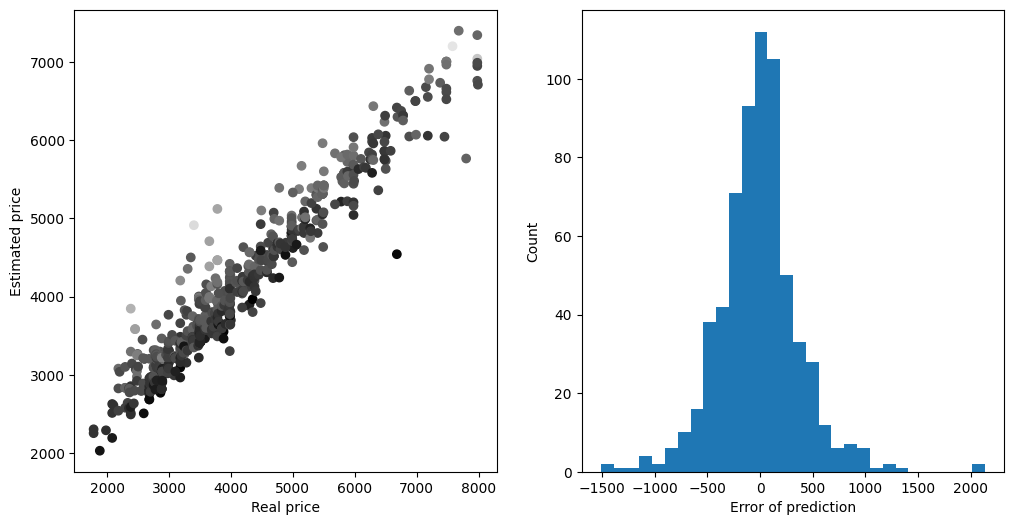

In [6]:
fig = plt.figure(figsize=(12, 6))
[ax1, ax2] = fig.subplots(1, 2)
_ = ax1.scatter(df["price"], df["price_estimate"], c=df["exclusive_area"], cmap="gray")
ax1.set_xlabel("Real price")
ax1.set_ylabel("Estimated price")
price_error = df["price"] - df["price_estimate"]
_ = ax2.hist(price_error, bins=30)
ax2.set_xlabel("Error of prediction")
ax2.set_ylabel("Count")
print(f"Mu={price_error.to_numpy().mean()} Std={price_error.to_numpy().std()}")

## Distribution for CP value

CP value is the ration between estimated price and real price.
It assumes that the model's predictions are fundamentally accurate, and that the prediction errors come from different sellers' psychological expectations.

When we have a model that also works well on the test set, we can use CP Value to estimate the profit margin.

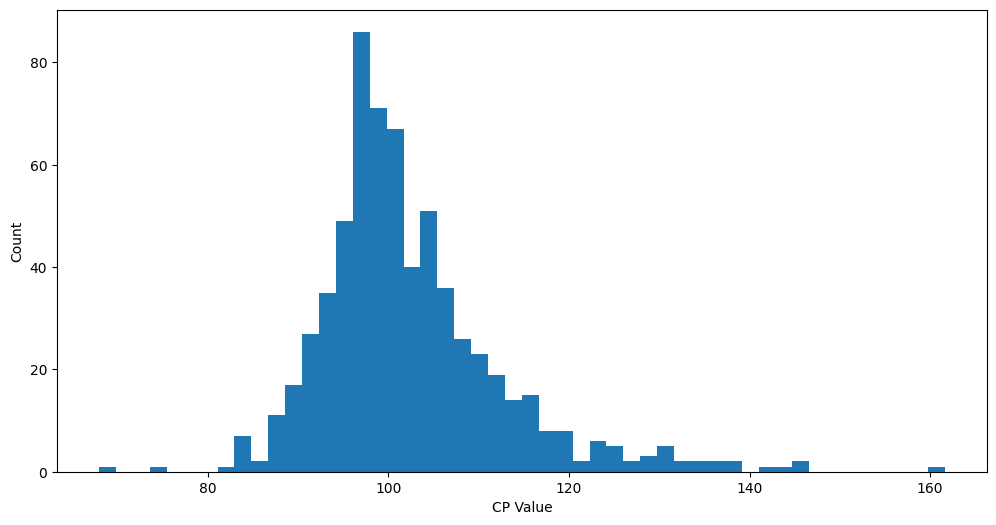

In [7]:
plt.rcParams['figure.figsize'] = [12, 6]
df["cp_value"] = df["price_estimate"] * 100.0 / df["price"]
plt.hist(df["cp_value"], bins=50)
plt.xlabel("CP Value")
_ = plt.ylabel("Count")

# Save The Result

Save the result to CSV file and order by CP value desc.

In [8]:
df.sort_values(by=["cp_value"], ascending=False).to_csv("data/result-xgb.csv", index=False)